# COVID-19 pandemic fighting plan

## Introduction
#### Content
The paper consists of the following parts:
* Introduction
* Notebook setup
* Data cleaning
* Exploratory data analysis
* Correlational analysis
* Conclusions
    * Overview and improvements for fighting plan for the pandemic
    * Ways to improve analysis

#### Briely about the dataset
There are 10 datasets:
* Case.csv which contains the following features:
    * case_id - the ID of the infection case
    * province - Special City / Metropolitan City / Province(-do)
    * city - City(-si) / Country (-gun) / District (-gu)
    * group - TRUE: group infection / FALSE: not group
    * infection_case - the infection case (the name of group or other cases)
    * confirmed - the accumulated number of the confirmed
    * latitude - the latitude of the group (WGS84)
    * longitude - the longitude of the group (WGS84)
* PatientInfo.csv which contains the following features:
    * patient_id - the ID of the patient
    * sex - the sex of the patient
    * age - the age of the patient (in XXs notion)
    * country - the country of the patient
    * province - the province of the patient
    * city - the city of the patient
    * infection_case - the case of infection
    * infected_by - the ID of who infected the patient
    * contact_number - the number of contacts with people
    * symptom_onset_date - the date of symptom onset
* Policy.csv which contains the following features:
    * policy_id - the ID of the policy
    * country - the country that implemented the policy
    * type - the type of the policy
    * gov_policy - the policy of the government
    * detail - the detail of the policy
    * start_date - the start date of the policy
    * end_date - the end date of the policy
* Region.csv which contains the following features:
    * code - the code of the region
    * province - Special City / Metropolitan City / Province(-do)
    * city - City(-si) / Country (-gun) / District (-gu)
    * latitude - the latitude of the visit (WGS84)
    * longitude - the longitude of the visit (WGS84)
    * elementary_school_count - the number of elementary schools
    * kindergarten_count - the number of kindergartens
    * university_count - the number of universities
    * academy_ratio - the ratio of academies
    * elderly_population_ratio - the ratio of the elderly population
* SearchTrend.csv which contains the following features:
    * date in YYYY-MM-DD format
    * cold - the search volume of 'cold' in Korean language
    * flu - the search volume of 'flu' in Korean language
    * pneumonia - the search volume of 'pneumonia' in Korean language
    * coronavir/ District (-gu)
    * fp_num - the number of floating population
* Time.csv which contains the following features:
    * date in YYYY-MM-DD format
    * time in Time format (0 = AM 12:00 / 16 = PM 04:00)
    * test - the accumulated number of tests
    * negative - the accumulated number of negative results
    * confirmed - the accumulated number of positive results
    * released - the accumulated number of releases
    * deceased - the accumulated number of deceases
* TimeAge.csv which contains the following features:
    * date in YYYY-MM-DD format
    * time in Time format (0 = AM 12:00 / 16 = PM 04:00)
    * age - the age of patients (in XXs notion)
    * confirmed - the accumulated number of the confirmed
    * deceased - the accumulated number of the deceased
* TimeGender.csv which contains the following features:
    * date in YYYY-MM-DD format
    * time in Time format (0 = AM 12:00 / 16 = PM 04:00)
    * sex - the gender of patients
    * confirmed - the accumulated number of the confirmed
    * deceased - the accumulated number of the deceased
* TimeProvince.csv which contains the following features:
    * date in YYYY-MM-DD format
    * time in Time format (0 = AM 12:00 / 16 = PM 04:00)
    * province - the province of South Korea
    * confirmed - the accumulated number of the confirmed
    * released - the accumulated number of the released in the province
    * deceased - the accumulated number of the deceased
* Weather.csv which contains the following features:
    * code - the code of the region
    * province - Special City / Metropolitan City / Province(-do)
    * date in YYYY-MM-DD format
    * avg_temp - the average temperature
    * min_temp - the lowest temperature
    * max_temp - the highest temperature
    * precipitation - the daily precipitation
    * max_wind_speed - the maximum wind speed
    * most_wind_direction - the most frequent wind direction
    * avg_relative_humidity - the average relative humidity


## Notebook setup

In [193]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import pearsonr
from IPython.display import display, HTML
from datetime import datetime, timedelta
from tukey_fences import tukey_fences_method
from matplotlib.colors import LinearSegmentedColormap

In [8]:
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-pastel")
color_palette = {
    "confirmed": "#F7C404",
    "confirmed_m": "#DEB004",
    "released": "#56D3FF",
    "released_m": "#46ABCF",
    "deceased": "#63020F",
    "test": "#6182F7",
    "male": "#5C7DCF",
    "female": "#CF5CAC",
    }

In [2]:
Cases = pd.read_csv("Case.csv", index_col=0)

PatientInfo = pd.read_csv("PatientInfo.csv", index_col=0)
PatientInfo["symptom_onset_date"] = PatientInfo["symptom_onset_date"].apply(
    lambda x: pd.to_datetime(x, errors="coerce")
    if pd.notnull(x) and x != ""
    else x
    )
PatientInfo["confirmed_date"] = PatientInfo["confirmed_date"].apply(
    lambda x: pd.to_datetime(x, errors="coerce")
    if pd.notnull(x) and x != ""
    else x
    )
PatientInfo["released_date"] = PatientInfo["released_date"].apply(
    lambda x: pd.to_datetime(x, errors="coerce")
    if pd.notnull(x) and x != ""
    else x
    )
PatientInfo["deceased_date"] = PatientInfo["deceased_date"].apply(
    lambda x: pd.to_datetime(x, errors="coerce")
    if pd.notnull(x) and x != ""
    else x
    )


Policy = pd.read_csv("Policy.csv", index_col=0)
Policy["start_date"] = pd.to_datetime(Policy["start_date"])
Policy["end_date"] = pd.to_datetime(Policy["end_date"])

Region = pd.read_csv("Region.csv", index_col=0)

SearchTrend = pd.read_csv("SearchTrend.csv", index_col=0)
SearchTrend.index = pd.to_datetime(SearchTrend.index)


Time = pd.read_csv("Time.csv")
Time.set_index(["date"], inplace=True)
Time.index = pd.to_datetime(Time.index)

TimeAge = pd.read_csv("TimeAge.csv")
TimeAge.set_index(["date", "age"], inplace=True)
dates = pd.to_datetime(TimeAge.index.get_level_values("date"))
ages = TimeAge.index.get_level_values("age")
TimeAge.index = pd.MultiIndex.from_arrays([dates, ages], names=["date", "age"])

TimeGender = pd.read_csv("TimeGender.csv")
TimeGender["date"] = pd.to_datetime(TimeGender.date).dt.date
TimeGender.set_index(["date", "sex"], inplace=True)

TimeProvince = pd.read_csv("TimeProvince.csv")
TimeProvince["date"] = pd.to_datetime(TimeProvince.date).dt.date
TimeProvince.set_index(["date", "province"], inplace=True)
prov_dates = pd.to_datetime(TimeProvince.index.get_level_values("date"))
provinces = TimeProvince.index.get_level_values("province")
TimeProvince.index = pd.MultiIndex.from_arrays(
    [prov_dates, provinces], names=["date", "province"]
    )

Weather = pd.read_csv("Weather.csv")
Weather.set_index(["date", "province"], inplace=True)
weath_dates = pd.to_datetime(Weather.index.get_level_values("date"))
w_provinces = Weather.index.get_level_values("province")
Weather.index = pd.MultiIndex.from_arrays(
    [weath_dates, w_provinces], names=["date", "province"]
    )

## Data Cleaning

### Missing values

In [89]:
def check_missing(df):
    if df.columns[df.isnull().any()].any():
        missing_values_at = ", ".join(df.columns[df.isnull().any()].unique())
        nan_rows = df.isna().sum(axis=1)
        total_nan_rows = (nan_rows > 0).sum()
        return (
            f"Missing value at {missing_values_at} feature(s).",
            total_nan_rows,
            f"{round(total_nan_rows*100/len(df), 2)} %",
            )
    else:
        return ("No missing values have been detected", 0, "0 %")


Datasets = {
    "Cases": Cases,
    "PatientInfo": PatientInfo,
    "Policy": Policy,
    "Region": Region,
    "SearchTrend": SearchTrend,
    "Time": Time,
    "TimeAge": TimeAge,
    "TimeGender": TimeGender,
    "TimeProvince": TimeProvince,
    "Weather": Weather,
    }
missing_values = pd.DataFrame(
    data=[(check_missing(df)) for df in Datasets.values()],
    index=Datasets.keys(),
    columns=[
        "Features having missing values",
        "Rows having missing values",
        "Percentage of rows having missing value"],
        )
missing_values.index.name = "Dataset name"
pd.set_option("display.max_colwidth", None)
pd.set_option("colheader_justify", "left")
missing_values

,Features having missing values,Rows having missing values,Percentage of rows having missing value
Dataset name,,,
Cases,No missing values have been detected,0,0 %
PatientInfo,"Missing value at sex, age, city, infection_case, infected_by, contact_number, symptom_onset_date, confirmed_date, released_date, deceased_date feature(s).",5165,100.0 %
Policy,"Missing value at detail, end_date feature(s).",37,60.66 %
Region,No missing values have been detected,0,0 %
SearchTrend,No missing values have been detected,0,0 %
Time,No missing values have been detected,0,0 %
TimeAge,No missing values have been detected,0,0 %
TimeGender,No missing values have been detected,0,0 %
TimeProvince,No missing values have been detected,0,0 %


### Duplicated records

In [90]:
def handle_duplicates(df, col=None):
    if col == None:
        if df.duplicated().any():
            duplicated_observations = df.duplicated().sum()
            df.drop_duplicates(keep="first", inplace=True)
            return f"Found and deleted {duplicated_observations} duplicate(s)."

        else:
            return "No duplicates found."
    else:
        if df.duplicated(subset=col).any():
            df.drop_duplicates(keep="first", inplace=True)
            duplicated_observations = df.duplicated().sum()
        else:
            return "No duplicates found."


DP_index = ["Cases", "Policy", "Region"]
DP_data = []
DP_data.append(handle_duplicates(Cases))
DP_data.append(handle_duplicates(Policy))
DP_data.append(handle_duplicates(Region, ["city", "latitude", "longitude"]))


duplicate_records = pd.DataFrame(
    data=DP_data, index=DP_index, columns=["Duplicates"]
    )
duplicate_records.index.name = "Dataset name"
duplicate_records

,Duplicates
Dataset name,
Cases,No duplicates found.
Policy,No duplicates found.
Region,No duplicates found.


Excluding the datasets from searching the duplicate values was intentional due to the following reasons:

* PatientInfo dataframe index is set to be a unique patient ID. If records had the same patient ID, an error would have occurred while reading the data.

* The other datasets use a date column or more as an index and this ensures that no two records having the same date are present. </br>
Here is a list of those datasets:
    * SearchTrend
    * Time
    * TimeAge
    * TimeGender
    * TimeProvince
    * Weather


### Handling outliers

In [3]:
Datasets = {
    "Cases": Cases,
    "PatientInfo": PatientInfo,
    "Region": Region,
    "SearchTrend": SearchTrend,
    "Time": Time,
    "TimeAge": TimeAge,
    "TimeGender": TimeGender,
    "TimeProvince": TimeProvince,
    "Weather": Weather,
}
Features_to_check = {
    "Cases": "confirmed",
    "PatientInfo": "contact_number",
    "Region": [
        "elementary_school_count",
        "kindergarten_count",
        "university_count",
        "academy_ratio",
        "elderly_population_ratio",
    ],
    "SearchTrend": ["cold", "flu", "pneumonia", "coronavirus"],
    "Time": ["test", "negative", "confirmed", "released", "deceased"],
    "TimeAge": ["confirmed", "deceased"],
    "TimeGender": ["confirmed", "deceased"],
    "TimeProvince": ["confirmed", "released", "deceased"],
    "Weather": [
        "avg_temp",
        "min_temp",
        "max_temp",
        "max_wind_speed",
        "most_wind_direction",
        "avg_relative_humidity",
        ]}

outlier_data = {}

for key in Datasets.keys():
    if isinstance(Features_to_check[key], list):
        for feature in Features_to_check[key]:
            out_list, proc = tukey_fences_method(Datasets[key], feature)
            outlier_data[(key, feature)] = [len(out_list), proc]
    else:
        out_list, proc = tukey_fences_method(
            Datasets[key], Features_to_check[key]
        )
        outlier_data[(key, Features_to_check[key])] = [len(out_list), proc]

outliers_found = pd.DataFrame(
    data=outlier_data.values(),
    index=outlier_data.keys(),
    columns=["Number of outliers", "Percentage of data loss"],
    )

#Tuckey Fences method unable to calculate outliers for mostly 0 value data
Weather_copy = Weather.loc[Weather.precipitation > 0].copy()
weather_list, weather_proc = tukey_fences_method(Weather_copy, "precipitation")
outliers_found.loc[("Weather", "precipitation"), :] = [
    len(weather_list),
    weather_proc,
    ]

outliers_found

Number of outliers  \
Cases        confirmed                               14.0   
PatientInfo  contact_number                          47.0   
Region       elementary_school_count                 19.0   
             kindergarten_count                      18.0   
             university_count                        13.0   
             academy_ratio                            2.0   
             elderly_population_ratio                 0.0   
SearchTrend  cold                                    94.0   
             flu                                     86.0   
             pneumonia                               54.0   
             coronavirus                            186.0   
Time         test                                     0.0   
             negative                                 0.0   
             confirmed                                0.0   
             released                                 0.0   
             deceased                                 0.0   
TimeAge      confirmed                                0.0   
             deceased                                 0.0   
TimeGender   confirmed                                0.0   
             deceased                                 0.0   
TimeProvince confirmed                              428.0   
             released                               351.0   
             deceased                               402.0   
Weather      avg_temp                                 0.0   
             min_temp                                 0.0   
             max_temp                                 0.0   
             max_wind_speed                         186.0   
             most_wind_direction                      0.0   
             avg_relative_humidity                    0.0   
             precipitation                          150.0   

                                      Percentage of data loss  
Cases        confirmed                                 8.05 %  
PatientInfo  contact_number                            0.91 %  
Region       elementary_school_count                   7.79 %  
             kindergarten_count                        7.38 %  
             university_count                          5.33 %  
             academy_ratio                             0.82 %  
             elderly_population_ratio                   0.0 %  
SearchTrend  cold                                      5.72 %  
             flu                                       5.24 %  
             pneumonia                                 3.29 %  
             coronavirus                              11.33 %  
Time         test                                       0.0 %  
             negative                                   0.0 %  
             confirmed                                  0.0 %  
             released                                   0.0 %  
             deceased                                   0.0 %  
TimeAge      confirmed                                  0.0 %  
             deceased                                   0.0 %  
TimeGender   confirmed                                  0.0 %  
             deceased                                   0.0 %  
TimeProvince confirmed                                15.45 %  
             released                                 12.67 %  
             deceased                                 14.51 %  
Weather      avg_temp                                   0.0 %  
             min_temp                                   0.0 %  
             max_temp                                   0.0 %  
             max_wind_speed                            0.71 %  
             most_wind_direction                        0.0 %  
             avg_relative_humidity                      0.0 %  
             precipitation                             4.29 %

Although the majority of the outliers cannot be treated without domain knowledge there are several outliers in the **PatientInfo** datatet *contact_number* column that are evident mistakes. The values entered are the patient IDs instead of a number of contacts. Those will be replaced with 1.

In [124]:
out_conf_ids, out_conf_proc = tukey_fences_method(
    PatientInfo, "contact_number"
)
pd.options.display.float_format = "{:.2f}".format
Contact_outliers = (
    PatientInfo.iloc[out_conf_ids]
    .loc[:, ["sex", "age", "infected_by", "contact_number"]]
    .sort_values(by="contact_number", ascending=False)
)

Contact_outliers.head(5)

,sex,age,infected_by,contact_number
patient_id,,,,
6100000098,male,60s,6100000097,6100000099.00
6100000097,female,60s,NaN,6100000098.00
1000000819,NaN,NaN,NaN,1000000796.00
1200000031,female,60s,NaN,1160.00
1100000001,male,10s,NaN,1091.00


In [125]:
replaced_id = []
for index, row in PatientInfo.iloc[out_conf_ids].iterrows():
    if PatientInfo.index.isin([int(row["contact_number"])]).any():
        PatientInfo.loc[index, "contact_number"] = 1
        replaced_id.append(index)

Replaced_outliers = PatientInfo.loc[
    replaced_id, ["sex", "age", "infected_by", "contact_number"]
]
PatientInfo["contact_number"] = pd.to_numeric(
    PatientInfo["contact_number"], errors="coerce"
)
Replaced_outliers

,sex,age,infected_by,contact_number
patient_id,,,,
1000000819,NaN,NaN,NaN,1.00
6100000097,female,60s,NaN,1.00
6100000098,male,60s,6100000097,1.00


## Exploritory data analysis

The analysis will try to evaluate how well have the pandemic been handled over and time period.
This should be achieved by answering the following questions:
* During what period number of confirmed COVID-19 cases rise most steadily?
* Was the rate of tests conducted per confirmed cases steady?
* Which provinces had the highest numbers of confirmed COVID-19 people? 
* Which infection cases caused those provinces to have the highest numbers of COVID-19 infections?
* Do provinces having the highest numbers of infected stand out in terms of education or elderly facilities? 
* What were more vulnerable groups age and gender-wise? 
* What are the survival rate, time to heal, and time till death for the given age groups?
* Were the policies implemented on time-based on the number of people confirmed with COVID-19? 
* Does the weather of most affected provinces correlate with numbers of confirmed infections? 
* Do search trends correlate with the number of people having been confirmed with COVID-19? 

In [3]:
def first_double_increase(col):
    prev_values = col.shift(1)
    double_condition = (col >= 2 * prev_values) & (col > 10)
    if double_condition.any():
        result_index = double_condition.idxmax()
        result_value = col[result_index]
        return result_index, result_value
    else:
        return None, None

### Period during which numbers of confirmed COVID-19 cases rose the most 

Chart bellow illustrates that during period between 20202-02-19 and 2020-03-13 South Korea has experiences the most drastic rises and falls in confirmed cases of COVID-19. Afterwards followed spiking numbers of recovered patients and the highest number of deaths. Comparing the number of deaths to recovered patients it seems that the survival rate is quite high. On 2020-04-18 confirmed cases decreased roughly to the same numbers as found on 2020-02-19, thus this period will be point of interest in my analysis and referenced as First Wave.

In [7]:
def plot_point(
    plt, x, y, m_label, m_shape, elevate_x, elevate_y, text_prompt, color, text_color = "grey"
):
    plt.plot(
        x,
        y,
        m_shape,
        label=m_label,
        markersize=6,
        color=color,
        alpha=0.4,
        )
    plt.text(
        x + timedelta(days=elevate_x),
        y + elevate_y,
        f"{x.date()}:\n {round(y)} {text_prompt}",
        ha="center",
        va="center",
        fontsize="small",
        color= text_color,
        )

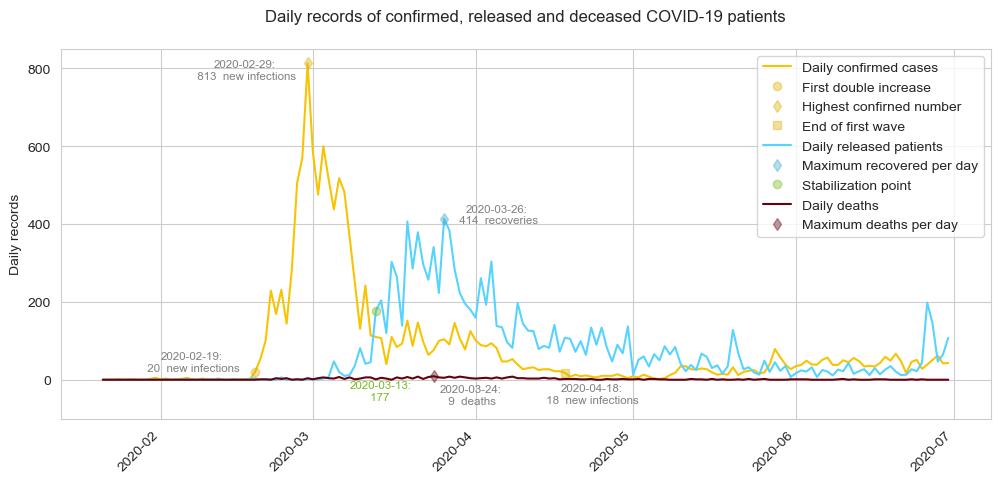

In [8]:
Time["Confirmed_Increases"] = Time["confirmed"].diff()
Time["Confirmed_Increases"].loc[0] = 0
Time["Released_Increases"] = Time["released"].diff()
Time["Released_Increases"].loc[0] = 0
Time["Deceased_Increases"] = Time["deceased"].diff()
Time["Deceased_Increases"].loc[0] = 0

plt.figure().set_figwidth(12)
plt.xticks(rotation=45, ha="right")
plt.ylim(-100, 850)
plt.ylabel("Daily records")
plt.title(
    "Daily records of confirmed, released and deceased COVID-19 patients",
    pad=20,
    )

plt.plot(
    Time["Confirmed_Increases"],
    label="Daily confirmed cases",
    color=color_palette["confirmed"],
    )

x, y = first_double_increase(Time["Confirmed_Increases"])

plot_point(
    plt,
    x,
    y,
    "First double increase",
    "o",
    -12,
    25,
    " new infections",
    color_palette["confirmed_m"],
    )

xmax = Time["Confirmed_Increases"].idxmax()
ymax = Time["Confirmed_Increases"].max()
plot_point(
    plt,
    xmax,
    ymax,
    "Highest confirned number",
    "d",
    -12,
    - 17,
    " new infections",
    color_palette["confirmed_m"],
    )


end_of_first_wave = (Time["Confirmed_Increases"] < y) & (Time.index > xmax)
xend = Time[end_of_first_wave].index[0]
yend = Time.loc[xend, "Confirmed_Increases"]
plot_point(
    plt,
    xend,
    yend,
    "End of first wave",
    "s",
    5,
    - 55,
    " new infections",
    color_palette["confirmed_m"],
    )


plt.plot(
    Time["Released_Increases"],
    label="Daily released patients",
    color=color_palette["released"],
    )

xrmax = Time["Released_Increases"].idxmax()
yrmax = Time["Released_Increases"].max()
plot_point(
    plt,
    xrmax,
    yrmax,
    "Maximum recovered per day",
    "d",
    10,
    10,
    " recoveries",
    color_palette["released_m"],
    )


stable_condition = (
    Time["Released_Increases"].gt(Time["Confirmed_Increases"])
) & (Time["Released_Increases"].gt(100))
xstable = Time[stable_condition].index[0]
ystable = Time.loc[xstable, "Released_Increases"]
plot_point(
    plt,
    xstable,
    ystable,
    "Stabilization point",
    "o",
    1,
    -207,
    " ",
    "#76BD22",
    "#76BD22"
    )


plt.plot(
    Time["Deceased_Increases"],
    label="Daily deaths",
    color=color_palette["deceased"],
    )

xdmax = Time["Deceased_Increases"].idxmax()
ydmax = Time["Deceased_Increases"].max()
plot_point(
    plt,
    xdmax,
    ydmax,
    "Maximum deaths per day",
    "d",
    7,
    -49,
    " deaths",
    color_palette["deceased"],
    )

plt.legend()

Start_date = x
End_date = xend

### Rate of tests per person confirmed with COVID-19

At the beginning of the pandemic, the number of tests conducted per person confirmed with COVID-19 had a sharp rise. Unfortunately on February 18th, this number started to sharply decrease indicating that as the number of people confirmed with COVID-19 increased, the number of tests conducted has not increased at the same rate. In fact on the day when the most confirmed cases were detected the ratio was at one of the lowest points.  On the bright side, it seems that after that point the rate has been increasing steadily.

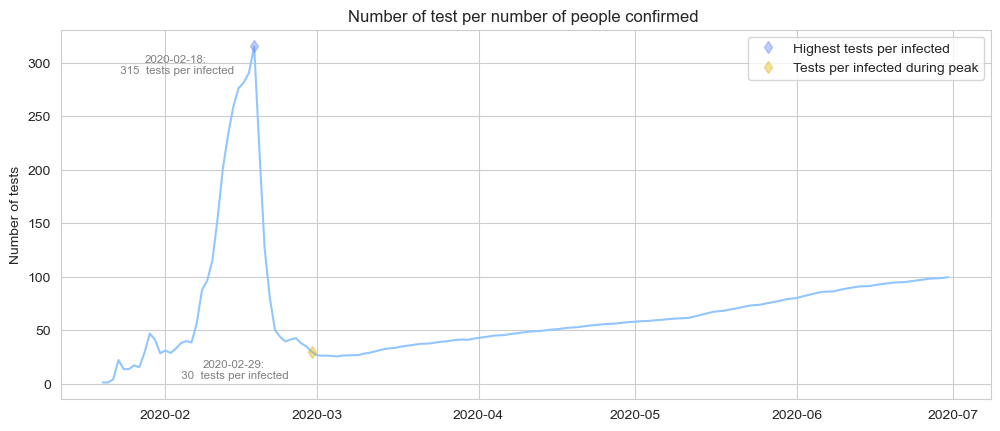

In [9]:
plt.figure().set_figwidth(12)
plt.title("Number of test per number of people confirmed ")
plt.ylabel("Number of tests")
Time["Test_per_confirmed"] = Time["test"] / Time["confirmed"]
plt.plot(Time["Test_per_confirmed"])

xtmax = Time["Test_per_confirmed"].idxmax()
ytmax = Time["Test_per_confirmed"].max()
plot_point(
    plt,
    xtmax,
    ytmax,
    "Highest tests per infected",
    "d",
    -15,
    -17,
    " tests per infected",
    color_palette["test"],
    )

xtmix = xmax
ytmix = Time.loc[xtmix, "Test_per_confirmed"]
plot_point(
    plt,
    xtmix,
    ytmix,
    "Tests per infected during peak",
    "d",
    -15,
    -17,
    " tests per infected",
    color_palette["confirmed_m"],
    )

plt.legend();

### Most affected provinces

The chart below illustrates accumulated number of people confirmed with COVID-19. It is striking to see that Daegu province has had the highest numbers. Second to that is 
Gyeongsangbuk-do province has nearly 7 times less confirmed cases than Daegu. Seoul and Gyeonggi-do provinces have had similar numbers of infected people and reached the peak of 1000 people to have been infected on June. The other provinces' accumulative numbers of people confirmed with COVID-19 during January - July have not reached 500 (Incheon having the highest - 341). Due to this, the analysis will instead focus on the 4 most infected provices -  Daegu,
Gyeongsangbuk-doo, Seoul, and Gyeonggi-do provinces.

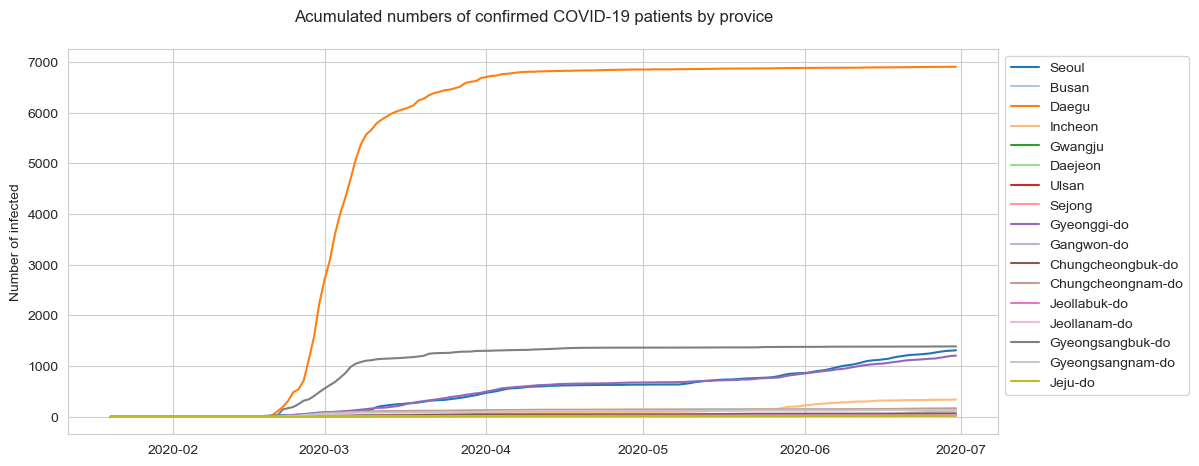

In [10]:
for city in TimeProvince.index.get_level_values(1).unique():
    Conf_increase_per_day = TimeProvince.groupby(level="province")[
        "confirmed"
    ].diff()

TimeProvince["Confirmed_Increases"] = Conf_increase_per_day

palette = sns.color_palette("tab20", 17)
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
sns.lineplot(
    data=TimeProvince,
    x=TimeProvince.index.get_level_values(0),
    y="confirmed",
    hue=TimeProvince.index.get_level_values(1),
    palette=palette,
    ax=ax,
    )

handles, labels = ax.get_legend_handles_labels()
city_color_map = {
    label: handle.get_color() for label, handle in zip(labels, handles)
    }

plt.ylabel("Number of infected")
plt.title(
    "Acumulated numbers of confirmed COVID-19 patients by provice", pad=20
    )
plt.xlabel("")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1));

### Most affected provinces: Daily increases

The highest daily confirmed number on 2020-02-29 which could be seen in previous charts does in fact mainly consist of people from Daegu province. Gyeongsangbuk-do, Seoul, and Gyeonggi-do provinces have their daily confirmed number peaks much later. We can only speculate that Daegu province people have spread COVID-19 to other provinces however it is undeniable that Daegu province did not control the spred as well as Gyeongsangbuk-do regardless starting with similar daily findings of infected people. 

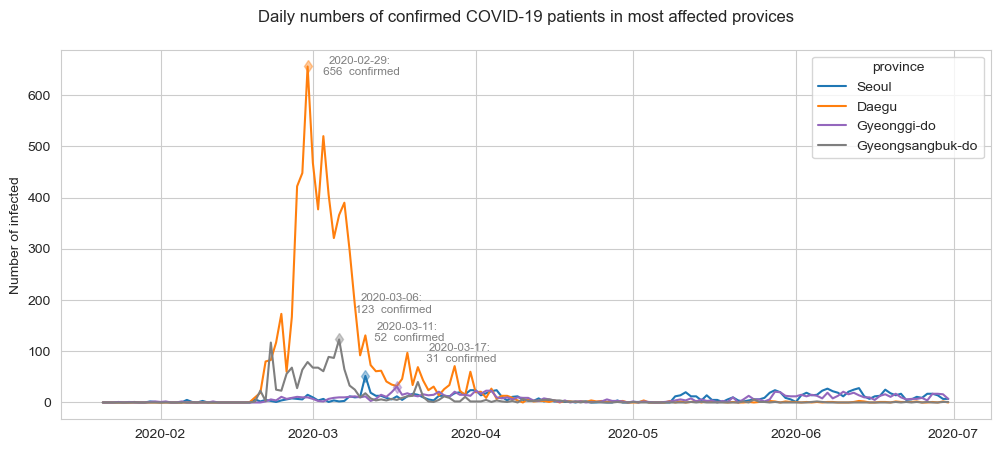

In [11]:
plt.figure().set_figwidth(12)
last_date = TimeProvince.index.get_level_values("date").max()
last_date_df = TimeProvince.xs(last_date, level="date")
high_confirmed_df = last_date_df[last_date_df["confirmed"] > 1000]
cities_with_highest_confirmed = high_confirmed_df.index.tolist()
mask = TimeProvince.index.get_level_values("province").isin(
    cities_with_highest_confirmed
    )

sns.lineplot(
    data=TimeProvince[mask],
    x=TimeProvince[mask].index.get_level_values(0),
    y="Confirmed_Increases",
    hue=TimeProvince[mask].index.get_level_values(1),
    palette=city_color_map,
    )

xDmax = TimeProvince.xs(
    'Daegu', level = 'province'
    )["Confirmed_Increases"].idxmax()
yDmax = TimeProvince.xs(
    'Daegu', level = 'province'
    )["Confirmed_Increases"].max()
plot_point(
    plt,
    xDmax,
    yDmax,
    "Maximum confirmed per day",
    "d",
    10,
    0,
    " confirmed",
    city_color_map['Daegu'],
    )


xGmax = TimeProvince.xs(
    'Gyeongsangbuk-do', level = 'province'
    )["Confirmed_Increases"].idxmax()
yGmax = TimeProvince.xs(
    'Gyeongsangbuk-do', level = 'province'
    )["Confirmed_Increases"].max()
plot_point(
    plt,
    xGmax,
    yGmax,
    "Maximum confirmed per day",
    "d",
    10,
    70,
    " confirmed",
    city_color_map['Gyeongsangbuk-do'],
    )

xGGmax = TimeProvince.xs(
    'Gyeonggi-do', level = 'province'
    )["Confirmed_Increases"].idxmax()
yGGmax = TimeProvince.xs(
    'Gyeonggi-do', level = 'province'
    )["Confirmed_Increases"].max()
plot_point(
    plt,
    xGGmax,
    yGGmax,
    "Maximum confirmed per day",
    "d",
    12,
    65,
    " confirmed",
    city_color_map['Gyeonggi-do'],
    )

xSmax = TimeProvince.xs(
    'Seoul', level = 'province'
    )["Confirmed_Increases"].idxmax()
ySmax = TimeProvince.xs(
    'Seoul', level = 'province'
    )["Confirmed_Increases"].max()
plot_point(
    plt,
    xSmax,
    ySmax,
    "Maximum confirmed per day",
    "d",
    8,
    85,
    " confirmed",
    city_color_map['Seoul'],
    )

plt.ylabel("Number of infected")
plt.title(
    "Daily numbers of confirmed COVID-19 patients in most affected provices",
    pad=20,
    )
plt.xlabel("");

### Most affected provinces: Acumulate released and deceased numbers

As expected, due to high confirmed numbers, the numbers of released and deceased people are higher in  Daegu compared to other provinces. The numbers of released people seem to have a similar trend as the numbers of confirmed people. The only significant difference we may see is that Seoul province people show a better survival rate than people from Gyeonggi-do province. 

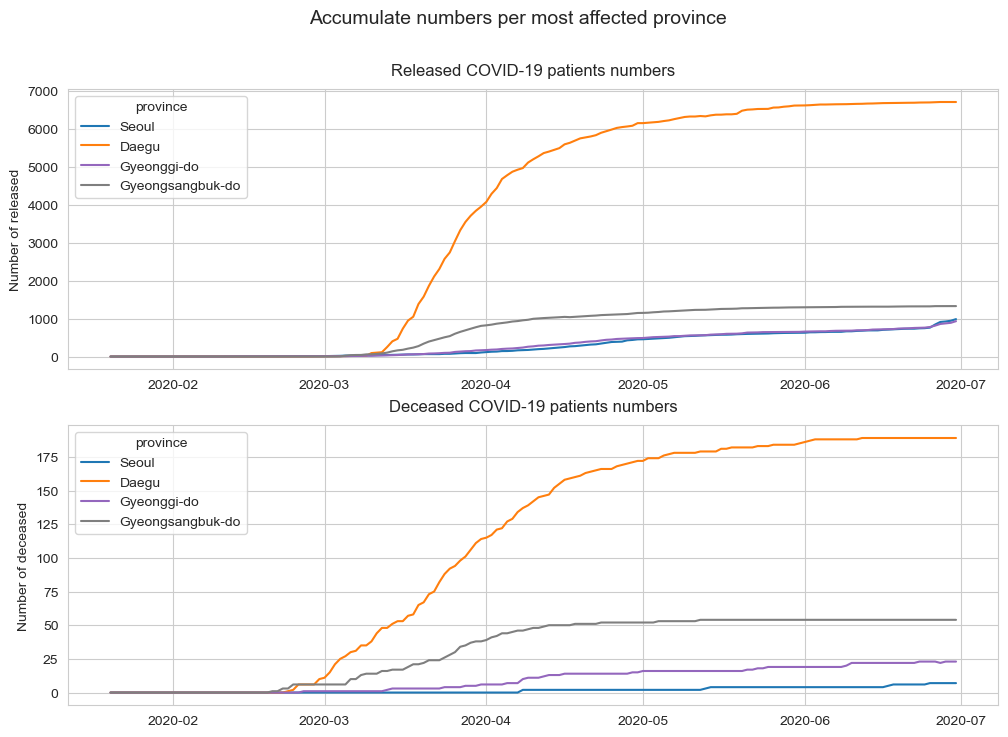

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plt.suptitle("Accumulate numbers per most affected province", fontsize=14)

sns.lineplot(
    data=TimeProvince[mask],
    x=TimeProvince[mask].index.get_level_values(0),
    y="released",
    hue=TimeProvince[mask].index.get_level_values(1),
    palette=city_color_map,
    ax=ax[0],
    )
ax[0].set_ylabel("Number of released")
ax[0].set_title("Released COVID-19 patients numbers", pad=10)
ax[0].set_xlabel("")

sns.lineplot(
    data=TimeProvince[mask],
    x=TimeProvince[mask].index.get_level_values(0),
    y="deceased",
    hue=TimeProvince[mask].index.get_level_values(1),
    palette=city_color_map,
    ax=ax[1],
    )
ax[1].set_ylabel("Number of deceased")
ax[1].set_title("Deceased COVID-19 patients numbers", pad=10)
ax[1].set_xlabel("");

### Most affected provinces: Infection cases

Shincheonji Church, contact with patients, and overseas inflow are the major infection cases for the 4 provinces. Shincheonji Church infection case seems to be the main reason why the Daegu and Gyeongsangbuk-do province number of people confirmed with COVID-19 was that high. Gyeonggi-do and Seoul province overseas inflow was one of the main reasons for the increase. Contact with a patient as well caused a high number of infected people and gave a hint that some government policies may have not been implemented on time.

In [18]:
the_4_cities = Cases[
    Cases["province"].isin(cities_with_highest_confirmed)
].loc[:, ["province", "infection_case", "confirmed"]]

the_4_cities_pvt = the_4_cities.pivot(
    columns="province", values="confirmed", index="infection_case"
    )

mask = the_4_cities_pvt > 100

the_4_cities_pvt.name = "Cases bringing highest confirmed numbers"
the_4_cities_pvt = (
    the_4_cities_pvt[mask]
    .sort_values(by="Daegu", ascending=False)
    .dropna(how="all")
    )
Severe_cases = the_4_cities_pvt.index

total_affected_cases = pd.Series(
    Cases[Cases["province"].isin(cities_with_highest_confirmed)]
    .groupby(["province"])["confirmed"]
    .sum()
    .sort_values(ascending=False)
    )
the_4_cities_pvt.loc["Complete Infected Numbers"] = total_affected_cases.T

print("                    Cases bringing highest confirmed numbers\n")
the_4_cities_pvt

                    Cases bringing highest confirmed numbers



province,Daegu,Gyeonggi-do,Gyeongsangbuk-do,Seoul
infection_case,,,,
Shincheonji Church,4511.00,NaN,566.00,NaN
contact with patient,917.00,NaN,190.00,162.00
etc,747.00,NaN,133.00,NaN
Second Mi-Ju Hospital,196.00,NaN,NaN,NaN
Hansarang Convalescent Hospital,124.00,NaN,NaN,NaN
Daesil Convalescent Hospital,101.00,NaN,NaN,NaN
Cheongdo Daenam Hospital,NaN,NaN,119.00,NaN
Itaewon Clubs,NaN,NaN,NaN,139.00
Richway,NaN,NaN,NaN,119.00


### Most afected province: Province statistics

Daegu, Seoul, and Gyeonggi-do provinces stand out by having high numbers (around 1.5 higher than the average) of nursing homes.</br> 
Seoul and Gyeonggi-do do share similar statistics other than nursing home numbers and this might suggest some similarity in how people got infected in the provinces.</br>
While Gyeongsangbuk-do does not have as many nursing homes, the elderly population and elderly alone ratio are higher than 75% of the provinces. This together with below average university, kindergarten, and elementary school counts might suggest that the population of the province is leaning toward the elderly more than other regions. As we will see that people in their 20s are the age groups that were most vulnerabe to be infected by COVID-19, low university count might indicate that they have not been infected in the province they originally were from. </br>
Daegu stands out having very high academy ratio and kindergarten count. As we will see further in the analysis the kindergartners had the lowest count of confirmed COVID-19 numbers thus this should not be considered as a contributing factor. On the other hand the high academy ratio might contributed to Daegu leading in the number of people confirmed with COVID-19.

In [26]:
df_4_cities = (
    Region[Region["province"].isin(cities_with_highest_confirmed)]
    .groupby("province")[
        [
            "elderly_population_ratio",
            "elderly_alone_ratio",
            "nursing_home_count",
            "university_count",
            "academy_ratio",
            "kindergarten_count",
            "elementary_school_count",
        ]
    ]
    .mean()
    )

df_4_cities.loc["REGION STATISTICS:"] = [
    " ", " ", " ", " ", " ", " ", " "
    ]

df_4_cities.loc["Average numbers"] = [
    Region["elderly_population_ratio"][:-1].mean(),
    Region["elderly_alone_ratio"][:-1].mean(),
    Region["nursing_home_count"][:-1].mean(),
    Region["university_count"][:-1].mean(),
    Region["academy_ratio"][:-1].mean(),
    Region["kindergarten_count"][:-1].mean(),
    Region["elementary_school_count"][:-1].mean(),
    ]

df_4_cities.loc["75% "] = [
    Region["elderly_population_ratio"][:-1].quantile(0.75),
    Region["elderly_alone_ratio"][:-1].quantile(0.75),
    Region["nursing_home_count"][:-1].quantile(0.75),
    Region["university_count"][:-1].quantile(0.75),
    Region["academy_ratio"][:-1].quantile(0.75),
    Region["kindergarten_count"][:-1].quantile(0.75),
    Region["elementary_school_count"][:-1].quantile(0.75),
    ]

df_4_cities.loc["Maximum numbers"] = [
    Region["elderly_population_ratio"][:-1].max(),
    Region["elderly_alone_ratio"][:-1].max(),
    Region["nursing_home_count"][:-1].max(),
    Region["university_count"][:-1].max(),
    Region["academy_ratio"][:-1].max(),
    Region["kindergarten_count"][:-1].max(),
    Region["elementary_school_count"][:-1].max(),
    ]

df_4_cities.loc["Minimum numbers"] = [
    Region["elderly_population_ratio"][:-1].min(),
    Region["elderly_alone_ratio"][:-1].min(),
    Region["nursing_home_count"][:-1].min(),
    Region["university_count"][:-1].min(),
    Region["academy_ratio"][:-1].min(),
    Region["kindergarten_count"][:-1].min(),
    Region["elementary_school_count"][:-1].min(),
    ]

df_4_cities

,elderly_population_ratio,elderly_alone_ratio,nursing_home_count,university_count,academy_ratio,kindergarten_count,elementary_school_count
province,,,,,,,
Daegu,17.03,7.97,1129.56,2.44,1.71,78.89,50.89
Gyeonggi-do,14.43,6.08,1280.69,3.81,1.42,139.81,79.81
Gyeongsangbuk-do,27.56,15.13,372.83,2.75,0.95,58.92,39.25
Seoul,15.74,5.92,1749.15,3.69,1.36,63.85,46.69
REGION STATISTICS:,,,,,,,
Average numbers,20.95,10.66,773.64,2.77,1.29,71.98,49.44
75%,27.27,14.65,682.50,3.00,1.62,55.00,36.00
Maximum numbers,40.26,24.70,22739.00,61.00,4.18,2237.00,1277.00
Minimum numbers,7.69,3.30,11.00,0.00,0.19,4.00,4.00


### Vulnerable groups identification: Gender comparison

The chart bellow displays the accumulated numbers of confirmed and deceased people from COVID-19. </br>
There were more women (around 1000) having been confirmed with COVID-19 than men. Despite that, COVID-19 brought more male deaths than female. </br> 
We cannot simply conclude that women are more viable than men as this phenomenon could have been caused by uneven gender distribution between age groups.

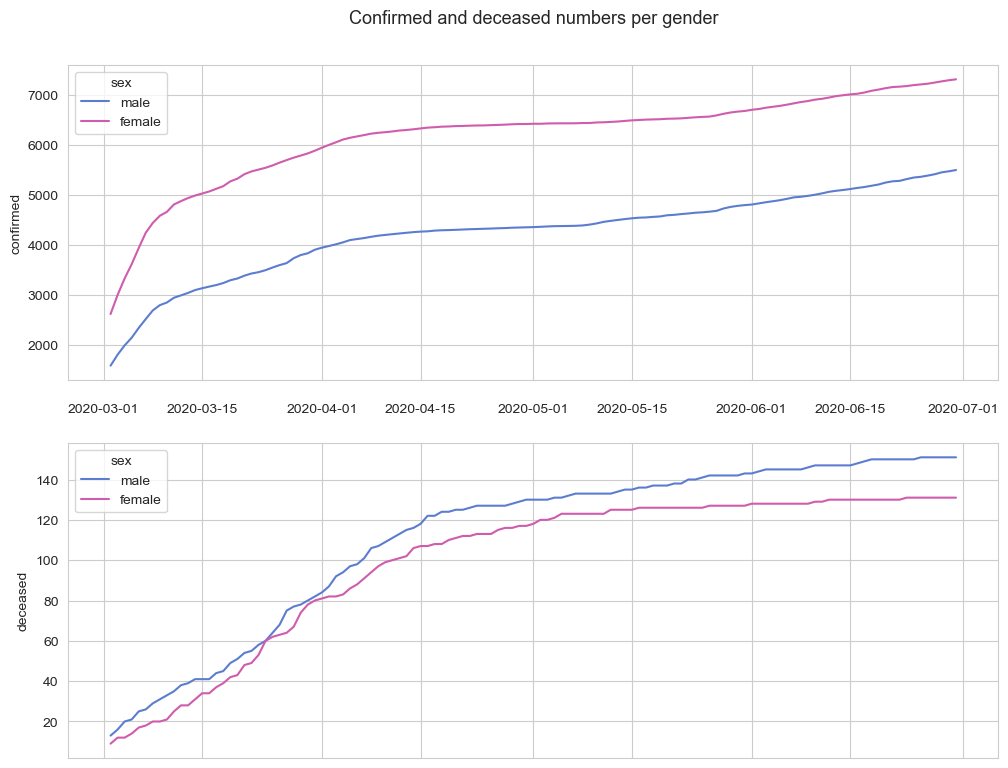

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(12, 9))
ax[0].set_title(
    "Confirmed and deceased numbers per gender", pad=30, fontsize=13
    )
palette = sns.color_palette([color_palette["male"], color_palette["female"]])

sns.lineplot(
    data=TimeGender,
    x=TimeGender.index.get_level_values(0),
    y="confirmed",
    hue=TimeGender.index.get_level_values(1),
    palette=palette,
    ax=ax[0],
    )
sns.lineplot(
    data=TimeGender,
    x=TimeGender.index.get_level_values(0),
    y="deceased",
    hue=TimeGender.index.get_level_values(1),
    palette=palette,
    ax=ax[1],
    )

for tick in ax[0].xaxis.get_major_ticks():
    tick.set_pad(13)
ax[1].set_xticklabels([])
ax[0].set_xlabel("")
ax[1].set_xlabel("");

### Vulnerable groups identification: Age groups

The most vulnerable to COVID-19 virus group is people in their 20s.</br>
Second to that are people in their 50s which seems unique as similar age groups in their 40s and 60s seem to have considerably fewer infected people. It is unexpected that people in their 60s have had slightly higher numbers of infected people than people in their 30s.</br>
People in their 10s, 70s, and 80s seem to form a cluster of similar numbers of infected people. This might be because the majority of their time is spent in the institutions like schools or nursing homes. </br>
statistics confirm that people in 00s seem to be most immune to COVID-19. </br>
</br>
When it comes to numbers of people deceased from COVID-19 it is evident that age plays a major role. Survival rate decreases once a person is in their 50s and as time goes by the likelihood of death increases as well. Awareness should be raised that age groups from 50s to 80s are most vulnerable to deaths from COVID-19. </br>
On the bright side people in their 20s having the highest numbers of confirmed infections all have recovered. So did the people in 00s and 10s.</br>
People in 30s have suffered 2 deaths and in 40s - 3 deaths.

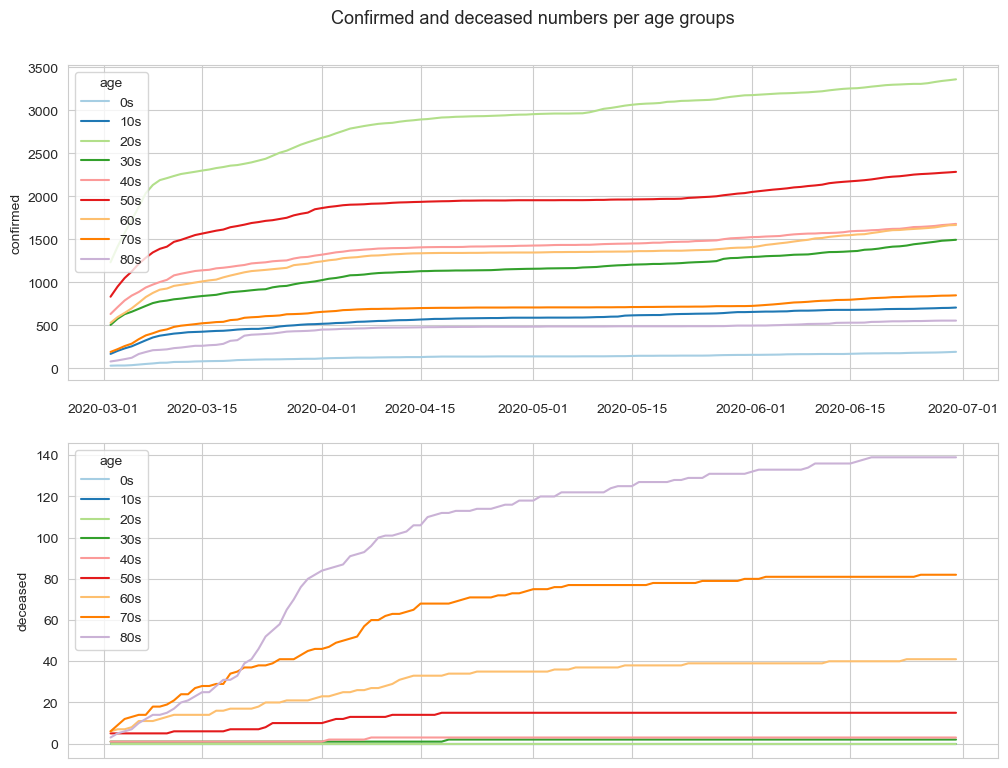

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(12, 9))
ax[0].set_title(
    "Confirmed and deceased numbers per age groups", pad=30, fontsize=13
    )
palette = sns.color_palette("Paired", 9)

sns.lineplot(
    data=TimeAge,
    x=TimeAge.index.get_level_values(0),
    y="confirmed",
    hue=TimeAge.index.get_level_values(1),
    palette=palette,
    ax=ax[0],
    )

sns.lineplot(
    data=TimeAge,
    x=TimeAge.index.get_level_values(0),
    y="deceased",
    hue=TimeAge.index.get_level_values(1),
    palette=palette,
    ax=ax[1],
    )

for tick in ax[0].xaxis.get_major_ticks():
    tick.set_pad(13)
ax[1].set_xticklabels([])
ax[0].set_xlabel("")
ax[1].set_xlabel("");

### Vulnerable groups identification: Gender vs Age groups comparison

If we look at the hospital records which is a fraction of data observed above we can see that similar numbers of male and female patience in their 20s were admitted. Out of both of the groups all patients have recovered. </br>
The biggest gender difference has been seen in people in their 50s and 80s where twice as many females were admitted when compared to males. Here the trend of male mortality being higher than female is not present (50s have are nearly equal). </br>
The above observed trend of males having higher mortality rate than females is only observed for people in their 60s and 70s. Those age groups treated numbers do not differ that much as the other age groups. In addition, the average time spend undiagnosed is shorter if not equal for males compared to female patients. </br>
There seems to be a trends present that females up to their 30s are being isolated less often than males of same ages. This suggests that young males might have less severe cases of COVID-19. It is reverse for the 40s and older males suggesting that older males might have more severe COVID-19 and need to be treated. This as well contributes to male higher mortality rate as COVID-19 seems to be more deadly for people in their 50s and older.  

In [157]:
treated_males = (
    PatientInfo[PatientInfo["sex"] == "male"].groupby("age")["sex"].count()
)
treated_females = (
    PatientInfo[PatientInfo["sex"] == "female"].groupby("age")["sex"].count()
)

isolated_males = (
    PatientInfo[
        (PatientInfo["sex"] == "male") & (PatientInfo["state"] == "isolated")
    ]
    .groupby("age")["sex"]
    .count()
)
isolated_females = (
    PatientInfo[
        (PatientInfo["sex"] == "female") & (PatientInfo["state"] == "isolated")
    ]
    .groupby("age")["sex"]
    .count()
)
deceased_males = (
    PatientInfo[
        (PatientInfo["sex"] == "male") & (PatientInfo["state"] == "deceased")
    ]
    .groupby("age")["sex"]
    .count()
)
deceased_females = (
    PatientInfo[
        (PatientInfo["sex"] == "female") & (PatientInfo["state"] == "deceased")
    ]
    .groupby("age")["sex"]
    .count()
)
unconfirmed_male = (
    PatientInfo[PatientInfo["sex"] == "male"]
    .groupby("age")["unconfirmed_infection"]
    .mean()
    .dt.round("D")
)
unconfirmed_female = (
    PatientInfo[PatientInfo["sex"] == "female"]
    .groupby("age")["unconfirmed_infection"]
    .mean()
    .dt.round("D")
)

arrays = [
    [
        "Treated",
        "Treated",
        "Isolated",
        "Isolated",
        "Deceased",
        "Deceased",
        "Undiagnosed",
        "Undiagnosed",
    ],
    [
        "Male",
        "Female",
        "Male",
        "Female",
        "Male",
        "Female",
        "Male",
        "Female",
    ],
]

max_length = max(len(name) for name in arrays[0])
padded_arrays = [
    [name.ljust(max_length) for name in group] for group in arrays
]

Col_tuples = list(zip(*padded_arrays))
index = pd.MultiIndex.from_arrays(arrays, names=["Group", "Gender"])


gender_age_statistics = pd.DataFrame(
    {
        "treated_male": treated_males,
        "treated_females": treated_females,
        "isolated_male": isolated_males,
        "isolated_female": isolated_females,
        "deceased_male": deceased_males,
        "deceased_female": deceased_females,
        "undiagnosed_male": unconfirmed_male,
        "undiagnosed_female": unconfirmed_female,
    }
)

gender_age_statistics.columns = index

gender_age_statistics

Group  Treated        Isolated        Deceased        Undiagnosed       
Gender    Male Female     Male Female     Male Female        Male Female
age                                                                     
0s        38.0     28     18.0   12.0      NaN    NaN      2 days 4 days
100s       NaN      1      NaN    NaN      NaN    NaN         NaT    NaT
10s      110.0     68     45.0   18.0      NaN    NaN      4 days 9 days
20s      440.0    457    125.0  109.0      NaN    NaN      5 days 4 days
30s      281.0    242    110.0   80.0      1.0    NaN      5 days 4 days
40s      210.0    307     63.0   82.0      2.0    NaN      6 days 6 days
50s      263.0    404     75.0  128.0      4.0    3.0      5 days 4 days
60s      212.0    270     74.0  102.0     11.0    1.0      3 days 6 days
70s       88.0    144     23.0   55.0     14.0    7.0      5 days 5 days
80s       56.0    114     22.0   43.0     10.0   15.0      4 days 6 days
90s       16.0     33      9.0   17.0      5.0    2.0      6 days    NaT

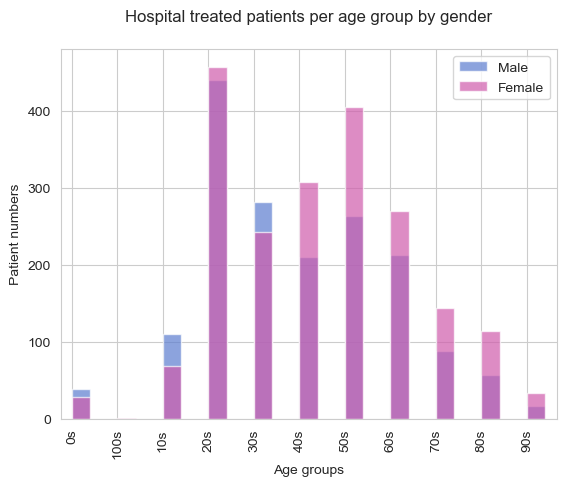

In [190]:
treated_male = gender_age_statistics[("Treated", "Male")]
treated_female = gender_age_statistics[("Treated", "Female")]
treated_male.plot(
    kind="bar",
    color=color_palette["male"],
    width=0.4,
    position=0,
    label="Male",
    alpha=0.7,
)
treated_female.plot(
    kind="bar",
    color=color_palette["female"],
    width=0.4,
    position=0,
    label="Female",
    alpha=0.7,
)
plt.xlabel("Age groups")
plt.ylabel("Patient numbers")
plt.title("Hospital treated patients per age group by gender", pad=20)
plt.legend();

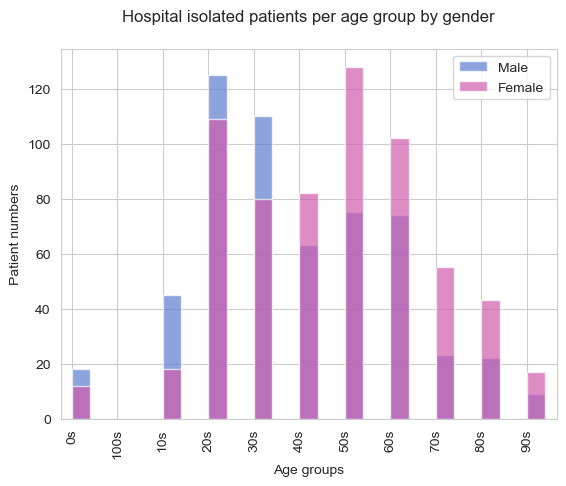

In [192]:
treated_male = gender_age_statistics[("Isolated", "Male")]
treated_female = gender_age_statistics[("Isolated", "Female")]
treated_male.plot(
    kind="bar",
    color=color_palette["male"],
    width=0.4,
    position=0,
    label="Male",
    alpha=0.7,
)
treated_female.plot(
    kind="bar",
    color=color_palette["female"],
    width=0.4,
    position=0,
    label="Female",
    alpha=0.7,
)
plt.xlabel("Age groups")
plt.ylabel("Patient numbers")
plt.title("Hospital isolated patients per age group by gender", pad=20)
plt.legend();

### Age groups: Infection cases for all provinces

The people in their 20s and 30s seem to be majorly infected by overseas inflow and contact with patients. However, records show that people in their 50s are the age group that contacts patients most often than others. It could be concluded that the contact with patient made a huge impact on 20s and 50s age groups having the highest number of infected people. 
</br>Hospital recods only have around 100 records out of around 500 confirmed cases of people in their 80s thus it cannot be determined the reason behind the infections. However, we could say that general trend dictates that the older generation infection cause is less likely to be an overseas inflow.

In [126]:
Hospital_case_records = pd.DataFrame(
    PatientInfo[PatientInfo["infection_case"].isin(Severe_cases)]
    .groupby(["infection_case", "age"])["age"]
    .count()
    )

Hospital_case_records = Hospital_case_records.unstack(level="age").sort_values(
    by=("age", "20s"), ascending=False
    )

total_age_cases = pd.Series(
    PatientInfo
    .groupby(["age"])["age"]
    .count()
    )
total_age_cases = total_age_cases.drop('100s')
total_age_cases = total_age_cases.reindex(
    Hospital_case_records.columns.get_level_values(1)
    )
Hospital_case_records.loc["Total patience records"] = total_age_cases.values

NaN_case_records = pd.Series(
    PatientInfo[PatientInfo["infection_case"].isna()]
    .groupby([ "age"])["age"]
    .count()
    )

Hospital_case_records.loc["Missing Infected reason numbers"] = NaN_case_records.values
print("                    Hospital records of infection cases by age\n")
Hospital_case_records

                    Hospital records of infection cases by age



age                                       \
age                             0s    10s    20s    30s    40s    50s      
infection_case                                                             
overseas inflow                 14.00  37.00 269.00 155.00  68.00  57.00   
contact with patient            35.00  73.00 172.00 136.00 171.00 235.00   
etc                              3.00  17.00 127.00  89.00  92.00 111.00   
Shincheonji Church                NaN   3.00  41.00  11.00  12.00  15.00   
Itaewon Clubs                     NaN    NaN  13.00   8.00   1.00   1.00   
Cheongdo Daenam Hospital          NaN    NaN   1.00   2.00   4.00   6.00   
Richway                           NaN    NaN    NaN    NaN   1.00    NaN   
Total patience records          66.00 178.00 899.00 523.00 518.00 667.00   
Missing Infected reason numbers 11.00  38.00 221.00  66.00  86.00 160.00   

                                                            
age                             60s    70s    80s    90s    
infection_case                                              
overseas inflow                  46.00   6.00   1.00   NaN  
contact with patient            168.00  73.00  38.00 11.00  
etc                              92.00  63.00  37.00  7.00  
Shincheonji Church               15.00   6.00    NaN   NaN  
Itaewon Clubs                     2.00   1.00    NaN   NaN  
Cheongdo Daenam Hospital          8.00    NaN    NaN   NaN  
Richway                           1.00   1.00   1.00   NaN  
Total patience records          482.00 232.00 170.00 49.00  
Missing Infected reason numbers 101.00  61.00  61.00 22.00

### Age groups: Statistics

It took on average from 3 to 6 days from feeling the COVID-19 symptoms to getting tested and confirmed with COVID-19. This time people in their 40s seem to be most diverse. People in their 80s on average took 5 days however the numbers are widely distributed as well. </br>
Pople in their 60s, 70s, 80s and 90s on average took similar time to recover - around 30 days though for 70s and 80s this number is more widely distributed. People in their 40s and 50s took around 24 days while 30s and 20s - 23 days. The healing period distribution of these 4 age groups is similar. For people in their 00s it took around 25 days. There has been recorded an extreme case of patient in 100s who took 66 days to recover. </br>
The average time passing from confirmed infection to death seems to be much shorter -  from 10 to 13 days for the elderly and around 5 days for people in their 50s. for people in their 70s this time is more diverse than other elderly age groups. </br>
Surprisingly people in their 90s and 10s are the ones with the highest average contact numbers - 55.5 and 36.6 respectively. People in their 20s and 50s despite being the age groups of most infected have remained with average contact numbers equal to 16.3.</br>
</br>
As you can see the above numbers have been calculated from the fraction of total numbers. The deceased rate has been calculated using the total confirmed number of COVID-19 infections displayed as confirmed count on the right. One in four people in their 80s confirmed with COVID-19 have died which is the highest deceased rate out of the the age groups. The second highest is for people in their 70s - nearly one in ten. Any people younger than people in their 70s have sharply decreasing deseased rates.

In [149]:
PatientInfo["unconfirmed_infection"] = (
    PatientInfo["confirmed_date"] - PatientInfo["symptom_onset_date"]
)
PatientInfo["treatmen_length"] = (
    PatientInfo["released_date"] - PatientInfo["confirmed_date"]
)
PatientInfo["deceased_length"] = (
    PatientInfo["deceased_date"] - PatientInfo["confirmed_date"]
)

unconfirmed = (
    PatientInfo.groupby("age")["unconfirmed_infection"].mean().dt.round("D")
)
unconfirmed_per_group = (
    PatientInfo.dropna(subset=["unconfirmed_infection"])
    .groupby("age")["unconfirmed_infection"]
    .count()
)
std_unconfirmed = (
    PatientInfo.groupby("age")["unconfirmed_infection"].std().dt.round("D")
)


treatment_len = (
    PatientInfo.groupby("age")["treatmen_length"].mean().dt.round("D")
)
treated_per_group = (
    PatientInfo.dropna(subset=["treatmen_length"])
    .groupby("age")["treatmen_length"]
    .count()
)
std_treated = PatientInfo.groupby("age")["treatmen_length"].std().dt.round("D")


deceased_len = (
    PatientInfo.groupby("age")["deceased_length"].mean().dt.round("D")
)
deceased_per_group = (
    PatientInfo.dropna(subset=["deceased_length"])
    .groupby("age")["deceased_length"]
    .count()
)
std_deceased = (
    PatientInfo.groupby("age")["deceased_length"].std().dt.round("D")
)

avg_contact_groups = (
    PatientInfo.groupby("age")["contact_number"].mean().round(1)
)
survival_rate_group = TimeAge["deceased"].tail(9) / TimeAge["confirmed"].tail(
    9
)

survival_rate_group.index = survival_rate_group.index.get_level_values(1)
confirmed_count = TimeAge["confirmed"].tail(9)
confirmed_count.index = confirmed_count.index.get_level_values(1)

arrays = [
    [
        "Undiagnosed COVID-19",
        "Undiagnosed COVID-19",
        "Undiagnosed COVID-19",
        "Treated COVID-19",
        "Treated COVID-19",
        "Treated COVID-19",
        "Deceased COVID-19",
        "Deceased COVID-19",
        "Deceased COVID-19",
        "Total patients",
        "Total patients",
        "Total patients",
    ],
    [
        "Average legth",
        "STD",
        "Group size",
        "Average legth",
        "STD",
        "Group size",
        "Average legth",
        "STD",
        "Group size",
        "Average contact nr.",
        "Deceased rate",
        "Confirmed count",
    ],
]

max_length = max(len(name) for name in arrays[0])
padded_arrays = [
    [name.ljust(max_length) for name in group] for group in arrays
]

Col_tuples = list(zip(*padded_arrays))
index = pd.MultiIndex.from_arrays(arrays, names=["Group", "Statistics"])


average_group_statistics = pd.DataFrame(
    {
        "Average unconfirmed": unconfirmed,
        "STD unconfirmed": std_unconfirmed,
        "Uncomfirmed group size": unconfirmed_per_group,
        "Average treatment length": treatment_len,
        "STD treated": std_treated,
        "Treaded group size": treated_per_group,
        "Average to die": deceased_len,
        "STD deceased": std_deceased,
        "Number of deaths": deceased_per_group,
        "Average contact number": avg_contact_groups,
        "Deceased rate": survival_rate_group,
        "Confirmed count": confirmed_count,
    }
)
average_group_statistics.columns = index
pd.reset_option("display.float_format")
average_group_statistics

Group      Undiagnosed COVID-19                    Treated COVID-19          \
Statistics        Average legth     STD Group size    Average legth     STD   
age                                                                           
0s                       3 days  2 days       11.0          25 days 13 days   
100s                        NaT     NaT        NaN          66 days     NaT   
10s                      5 days  7 days       22.0          21 days  9 days   
20s                      5 days  5 days      120.0          23 days 12 days   
30s                      4 days  5 days      111.0          23 days 12 days   
40s                      6 days 10 days       91.0          24 days 12 days   
50s                      4 days  4 days       75.0          24 days 12 days   
60s                      5 days  3 days       78.0          27 days 12 days   
70s                      5 days  4 days       28.0          33 days 19 days   
80s                      5 days  7 days       14.0          35 days 18 days   
90s                      6 days  1 days        2.0          29 days 11 days   

Group                 Deceased COVID-19                     \
Statistics Group size     Average legth     STD Group size   
age                                                          
0s                 19               NaT     NaT        NaN   
100s                1               NaT     NaT        NaN   
10s                65               NaT     NaT        NaN   
20s               409               NaT     NaT        NaN   
30s               211            0 days     NaT        1.0   
40s               241               NaT     NaT        NaN   
50s               300            5 days  7 days        7.0   
60s               173           11 days 15 days       11.0   
70s                83           13 days 20 days       19.0   
80s                60           11 days 13 days       22.0   
90s                14           10 days  4 days        6.0   

Group           Total patients                                
Statistics Average contact nr. Deceased rate Confirmed count  
age                                                           
0s                         2.7      0.000000           193.0  
100s                       NaN           NaN             NaN  
10s                       36.6      0.000000           708.0  
20s                       16.3      0.000000          3362.0  
30s                       16.7      0.001337          1496.0  
40s                       19.5      0.001785          1681.0  
50s                       16.3      0.006562          2286.0  
60s                       17.2      0.024580          1668.0  
70s                        6.6      0.096471           850.0  
80s                       12.8      0.250000           556.0  
90s                       55.5           NaN             NaN

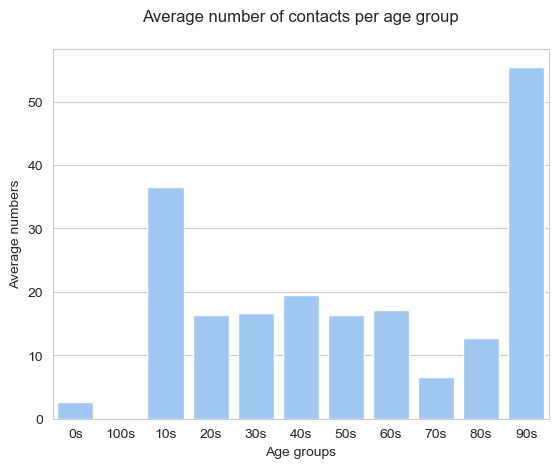

In [155]:
sns.barplot(
    x="age",
    y="Total patients",
    data=average_group_statistics.xs(
        "Average contact nr.", axis=1, level="Statistics"
    ),
)
plt.xlabel("Age groups")
plt.ylabel("Average numbers")
plt.title("Average number of contacts per age group", pad=20);

In [148]:
average_group_statistics.xs("Average contact nr.", axis=1, level="Statistics")

Group,Total patience
age,
0s,2.7
100s,NaN
10s,36.6
20s,16.3
30s,16.7
40s,19.5
50s,16.3
60s,17.2
70s,6.6


### Implemented policies to stop First Wave of infections

It seems that Infectiouns disease alert level has been raised according to daily conffirmed numbers. Four days after the first double increase Infectious Disease Alert Level was elevated to 4 (Red). </br>
*Preventing Contact with patient infection cases:* </br>
* The main drawback is the 6 day delay of implementing strong Social Distancing Campaign. Knowing that contact with a patient is one of the main causes of the infections, implementing strong Social Distancing Campaign on the day Infectious Disease Alert Level was elevated to 4 (Red) could have aided to decrease the number of people confirmed with COVID-19. Drive-Through Screening centers and Mask Distribution could have helped to decrease as well if implemented on the level 4 (Red) alert start date. </br>

*Preventing Overseas inflow infection cases:* </br>
* Overseas inflow brought more infections than contact with the patient, however only 3 (for people arriving from China, Hong Kong and Macau) out of 13 Special Immigration Procedures were implemented before confirmed numbers reached its peak. European and other countries were inluded in Special Immigration Procedure list only after 2020-03-09 starting with Japan. Mandatory 14-day Self-Quarantine has been implemented only after the First Wave has past, on 2020-04-01. This measure might have prevented overseas inflow infection cases moving forward however it still could have been implemented sooner. </br>

On the other hand Open Data and Self-Diagnosis App were implemented rather soon when Infectious disease alert level was 2 (Yellow) and 3 (Orange) respectively. I believe this raised enough awareness of COVID-19 and helped to keep undiagnosed period rather short - around 5 days.

In [13]:
def legend_without_duplicate_labels(figure):
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    figure.legend(by_label.values(), by_label.keys(), loc="upper left")

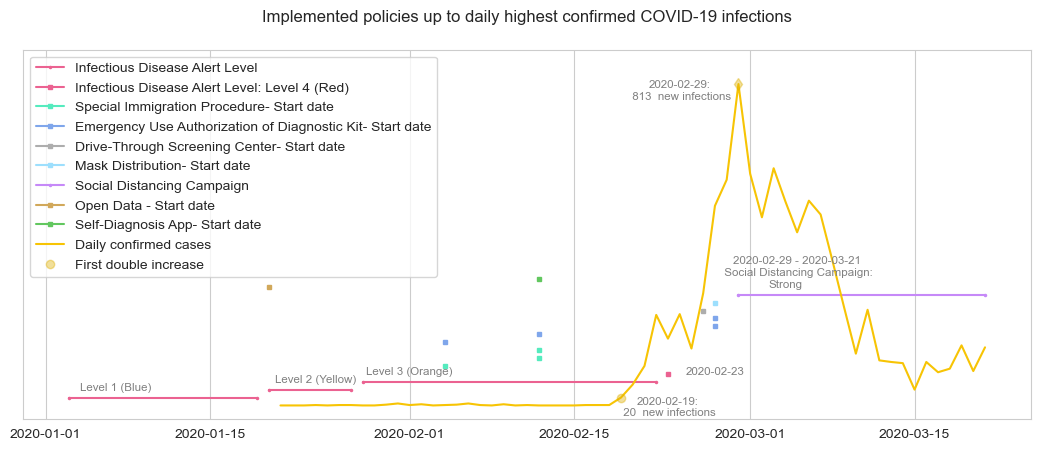

In [15]:
policy_color_palette = {
    "Infectious Disease Alert Level": "#EB6291",
    "Special Immigration Procedure": "#55EBBE",
    "Emergency Use Authorization of Diagnostic Kit": "#7FA6EB",
    "Drive-Through Screening Center": "#ADADAD",
    "Mask Distribution": "#9DDFFD",
    "Social Distancing Campaign": "#C689F8",
    "Self-Diagnosis App": "#62C75F",
    "Open Data ": "#D1A85A",
    }
plt.figure().set_figwidth(13)
plt.yticks([])
plt.ylim(-35, 900)
plt.title(
    "Implemented policies up to daily highest confirmed COVID-19 infections",
    pad=20,
    )



Stopping_procedures = Policy[Policy["start_date"] <= xmax]

elevate = 0

for index, row in Stopping_procedures.iterrows():
    if pd.notna(row["end_date"]):
        plt.plot(
            [row["start_date"], row["end_date"]],
            [(20 + elevate), (20 + elevate)],
            marker=".",
            label=row["gov_policy"],
            color=policy_color_palette[row["gov_policy"]],
            markersize=3,
            )
        plt.text(
            row["start_date"] + timedelta(days=4),
            (45 + elevate),
            row["detail"],
            ha="center",
            va="center",
            fontsize="small",
            color="grey",
            )
    else:
        if row["gov_policy"] != "Infectious Disease Alert Level":
            plt.plot(
                row["start_date"],
                (20 + elevate),
                marker="s",
                label=row["gov_policy"] + "- Start date",
                color=policy_color_palette[row["gov_policy"]],
                markersize=3,
                )
        else:
            plt.plot(
                row["start_date"],
                (20 + elevate),
                marker="s",
                label=row["gov_policy"] + ": " + row["detail"],
                color=policy_color_palette[row["gov_policy"]],
                markersize=3,
                )
    elevate += 20


social_distancing_start = Stopping_procedures[
    Stopping_procedures["gov_policy"] == "Social Distancing Campaign"
]["start_date"]

social_distancing_end = Stopping_procedures[
    Stopping_procedures["gov_policy"] == "Social Distancing Campaign"
]["end_date"]

red_alert_start = Stopping_procedures[(
    Stopping_procedures["gov_policy"] == "Infectious Disease Alert Level"
    ) & (Stopping_procedures["detail"] == "Level 4 (Red)")
]["start_date"]

plt.text(
    social_distancing_start + timedelta(days=5),
    350,
    social_distancing_start.iloc[0].strftime("%Y-%m-%d")
    + " - "
    + social_distancing_end.iloc[0].strftime("%Y-%m-%d")
    + "\n Social Distancing Campaign:",
    ha="center",
    va="center",
    fontsize="small",
    color="grey",
    )
plt.plot(
    Time.loc[
        : social_distancing_end.iloc[0].strftime("%Y-%m-%d"),
        "Confirmed_Increases",
    ],
    label="Daily confirmed cases",
    color=color_palette["confirmed"],
    )

plot_point(
    plt,
    x,
    y,
    "First double increase",
    "o",
    4,
    -25,
    " new infections",
    color_palette["confirmed_m"],
    )

plot_point(
    plt,
    xmax,
    ymax,
    "",
    "d",
    -5,
    - 17,
    " new infections",
    color_palette["confirmed_m"],
    )


plt.text(
    red_alert_start + timedelta(days=4),
    85,
    f"{red_alert_start.iloc[0].date()}",
    ha="center",
    va="center",
    fontsize="small",
    color="grey",
    )
legend_without_duplicate_labels(plt);

## Correlation analysis

### Numbers of people confirmed with COVID-19 in most affected  and weather

A strong positive correlation with statistical significance can be observed for average and maximal temperatures for all most affected provinces. </br>
Unlike the other 2 provinces, Seoul and Gyeonggi-do provinces which shared similar numbers of confirmed cases respectively display moderate and strong negative correlations with statistical significance when looking at average relative humidity. 

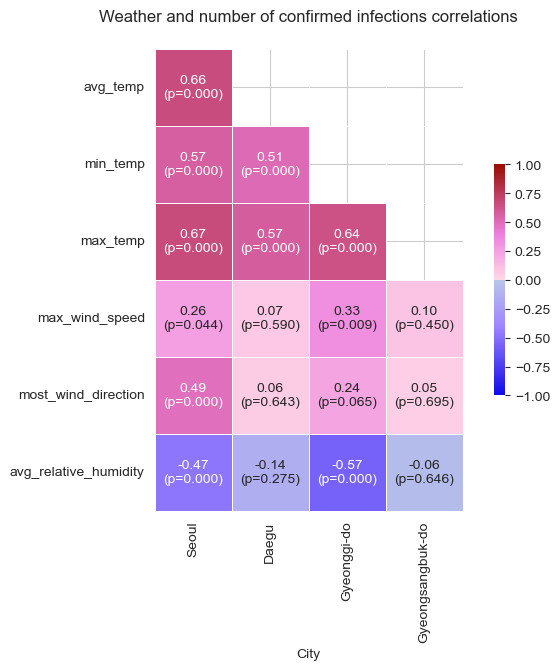

In [119]:
Covid_weather = Weather.loc[Start_date:End_date]
First_wave_conf = Time.loc[Start_date:End_date]["confirmed"]
Weather_parameter = [
    "avg_temp",
    "min_temp",
    "max_temp",
    "max_wind_speed",
    "most_wind_direction",
    "avg_relative_humidity",
    ]
metrics = ["Corr. value", "p - value"]
multi_index = pd.MultiIndex.from_product(
    [cities_with_highest_confirmed, metrics],
    names=["City", "Correlation Metric"],
    )

Weather_City_Corr_conf = pd.DataFrame(
    index=Weather_parameter, columns=multi_index
    )

for city in cities_with_highest_confirmed:
    for param in Weather_parameter:
        corr_val, p_val = pearsonr(
            Covid_weather.xs(city, level="province")[param], First_wave_conf
        )
        Weather_City_Corr_conf.loc[param, (city, "Corr. value")] = corr_val
        Weather_City_Corr_conf.loc[param, (city, "p - value")] = f"{p_val:.3f}"

corr_values = Weather_City_Corr_conf.xs(
    "Corr. value", axis=1, level="Correlation Metric"
).astype(float)
p_values = Weather_City_Corr_conf.xs(
    "p - value", axis=1, level="Correlation Metric"
    )

annotations = pd.DataFrame(
    index=corr_values.index, columns=corr_values.columns, dtype=object
    )
for col in annotations.columns:
    for idx in annotations.index:
        annotations.loc[
            idx, col
        ] = f"{corr_values.loc[idx, col]:.2f}\n(p={p_values.loc[idx, col]})"

mask = np.triu(np.ones_like(corr_values, dtype=bool), k=1)
colors = [
    (0.0, "#0D0AE8"),
    (0.3, "#A085FF"),
    (0.5, "#B8C6E8"),
    (0.5, "#FFD9E6"),
    (0.7, "#ED80DE"),
    (1.0, "#990C02"),
    ]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_values,
    mask=mask,
    cmap=custom_cmap,
    vmax=1.0,
    vmin=-1.0,
    center=0,
    annot=annotations,
    fmt="",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    xticklabels=cities_with_highest_confirmed,
    yticklabels=Weather_parameter,
    )
plt.title("Weather and number of confirmed infections correlations", pad=20);

In [116]:
Weather_City_Corr_conf

City                        Seoul                 Daegu           Gyeonggi-do  \
Correlation Metric    Corr. value p - value Corr. value p - value Corr. value   
avg_temp                 0.661932     0.000    0.675603     0.000    0.650574   
min_temp                 0.568126     0.000    0.511098     0.000     0.49119   
max_temp                 0.667432     0.000    0.574481     0.000    0.636533   
max_wind_speed           0.261222     0.044    0.071007     0.590    0.333985   
most_wind_direction      0.490048     0.000    0.061145     0.643    0.239465   
avg_relative_humidity   -0.471432     0.000   -0.143316     0.275   -0.569131   

City                            Gyeongsangbuk-do            
Correlation Metric    p - value      Corr. value p - value  
avg_temp                  0.000         0.590544     0.000  
min_temp                  0.000         0.457732     0.000  
max_temp                  0.000         0.598277     0.000  
max_wind_speed            0.009         0.099357     0.450  
most_wind_direction       0.065         0.051641     0.695  
avg_relative_humidity     0.000        -0.060496     0.646

### Numbers of people released with COVID-19 in most affected provinces and weather

An even stronger positive correlation with statistical significance can be observed for average, minimal, and maximal temperatures for all most affected provinces when comparing it to the numbers of people who recovered from COVID-19. This means that better weather conditions seem to aid patient recovery.</br>
Average relative humidity for Seoul and Gyeonggi-do provinces is moderately negatively correlated with statistical significance when compared to a number of recovered people.

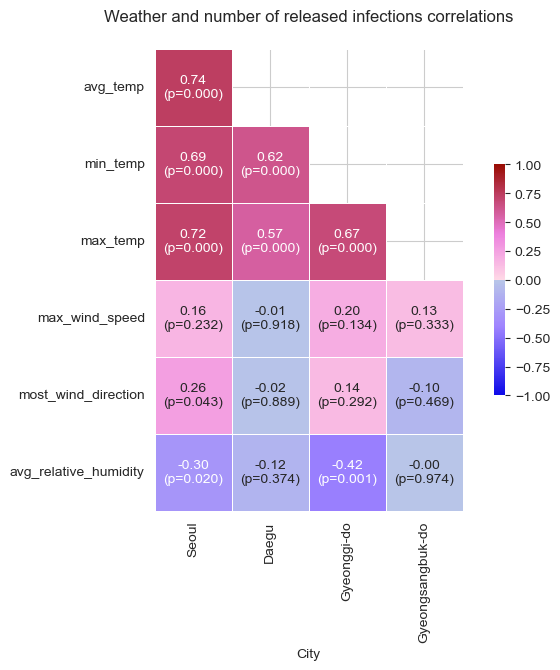

In [120]:
First_wave_relea = Time.loc[Start_date:End_date]["released"]
Weather_City_Corr_relea = pd.DataFrame(
    index=Weather_parameter, columns=multi_index
    )

for city in cities_with_highest_confirmed:
    for param in Weather_parameter:
        corr_val, p_val = pearsonr(
            Covid_weather.xs(city, level="province")[param], First_wave_relea
        )
        Weather_City_Corr_relea.loc[param, (city, "Corr. value")] = corr_val
        Weather_City_Corr_relea.loc[
            param, (city, "p - value")
        ] = f"{p_val:.3f}"

corr_values = Weather_City_Corr_relea.xs(
    "Corr. value", axis=1, level="Correlation Metric"
).astype(float)
p_values = Weather_City_Corr_relea.xs(
    "p - value", axis=1, level="Correlation Metric"
    )

annotations = pd.DataFrame(
    index=corr_values.index, columns=corr_values.columns, dtype=object
    )
for col in annotations.columns:
    for idx in annotations.index:
        annotations.loc[
            idx, col
        ] = f"{corr_values.loc[idx, col]:.2f}\n(p={p_values.loc[idx, col]})"

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_values,
    mask=mask,
    cmap=custom_cmap,
    vmax=1.0,
    vmin=-1.0,
    center=0,
    annot=annotations,
    fmt="",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    xticklabels=cities_with_highest_confirmed,
    yticklabels=Weather_parameter,
    )
plt.title("Weather and number of released infections correlations", pad=20);

In [113]:
Weather_City_Corr_relea

City                        Seoul                 Daegu           Gyeonggi-do  \
Correlation Metric    Corr. value p - value Corr. value p - value Corr. value   
avg_temp                 0.737126  0.000000    0.708776  0.000000    0.728683   
min_temp                 0.689102  0.000000    0.618538  0.000000    0.616735   
max_temp                 0.717511  0.000000      0.5697  0.000002    0.674645   
max_wind_speed           0.156534  0.232329   -0.013509  0.918405    0.195499   
most_wind_direction      0.262547  0.042703   -0.018428  0.888853    0.138198   
avg_relative_humidity   -0.300301  0.019739   -0.116757  0.374317   -0.423253   

City                            Gyeongsangbuk-do            
Correlation Metric    p - value      Corr. value p - value  
avg_temp               0.000000         0.601264  0.000000  
min_temp               0.000000         0.550331  0.000005  
max_temp               0.000000          0.60945  0.000000  
max_wind_speed         0.134404          0.12703  0.333444  
most_wind_direction    0.292330        -0.095357  0.468605  
avg_relative_humidity  0.000753        -0.004254  0.974264

##  Numbers of people confirmed with COVID-19 prior to first wave and search trends

Looking at the search trends of the period when the number of COVID-19 infections was low we can observe that searches for flu, pneumonia, and coronavirus are weakly correlated with no statistical significance to numbers of confirmed COVID-19 infections. This indicates that people were not that aware of COVID-19 once the pandemic started in Korea.

In [36]:
metrics = ["Corr. value", "p - value"]
Search_parameter = ["cold", "flu", "pneumonia", "coronavirus"]

Low_Covid_search = SearchTrend.loc[Time.index[1] : Start_date]
Prior_First_wave_conf = Time.loc[Time.index[1]:Start_date]["Confirmed_Increases"]

Low_Covid_Corr_conf = pd.DataFrame(index=Search_parameter, columns=metrics)


for param in Search_parameter:
    corr_val, p_val = pearsonr(Low_Covid_search[param], Prior_First_wave_conf)
    Low_Covid_Corr_conf.loc[param, "Corr. value"] = corr_val
    Low_Covid_Corr_conf.loc[param, "p - value"] = f"{p_val:.6f}"

Low_Covid_Corr_conf

,Corr. value,p - value
cold,0.072721,0.702541
flu,-0.111015,0.559202
pneumonia,-0.144272,0.446881
coronavirus,0.020916,0.912643


##  Numbers of people confirmed with COVID-19 during the first wave and search trends

During the First Wave, we can observe a weak, moderate, and strong positive correlation with statistical significance between cold, flu, and coronavirus searches respectfully and the numbers of people confirmed with COVID-19. It should mean that once the number of people confirmed with COVID-19 increased, public awareness on the matter increased as well.

In [35]:
First_wave = Time.loc[Start_date:End_date]["Confirmed_Increases"]
Covid_searches = SearchTrend.loc[Start_date:End_date]

Search_Corr_conf = pd.DataFrame(index=Search_parameter, columns=metrics)

for param in Search_parameter:
    corr_val, p_val = pearsonr(Covid_searches[param], First_wave)
    Search_Corr_conf.loc[param, "Corr. value"] = corr_val
    Search_Corr_conf.loc[param, "p - value"] = f"{p_val:.6f}"

Search_Corr_conf

,Corr. value,p - value
cold,0.24876,0.055288
flu,0.378292,0.002881
pneumonia,0.222458,0.087566
coronavirus,0.576305,0.000001


### Numbers of people confirmed with COVID-19 after to first wave and search trends

After the First Wave has ended searches for pneumonia and confirmed numbers seem to have retained a weak positive correlation with statistical significance. It hints that there is some skepticism  toward COVID-19. </br>
Coronavirus and flu become weakly negatively correlated however without statistical significance and cold - weakly negatively correlated with statistical significance. This might mean that people having a common cold might have increased.

In [33]:
Covid_searches = SearchTrend.loc[End_date: Time.index[-1] ]
After_First_wave = Time.loc[End_date: ]["Confirmed_Increases"]
After_First_wave = After_First_wave.drop("2020-06-30")
Search_Corr_conf = pd.DataFrame(index=Search_parameter, columns=metrics)


for param in Search_parameter:
    corr_val, p_val = pearsonr(Covid_searches[param], After_First_wave)
    Search_Corr_conf.loc[param, "Corr. value"] = corr_val
    Search_Corr_conf.loc[param, "p - value"] = f"{p_val:.6f}"

Search_Corr_conf

,Corr. value,p - value
cold,-0.238736,0.041945
flu,-0.187614,0.111957
pneumonia,0.27362,0.019162
coronavirus,-0.201989,0.086580


## Conclusions

### Overview and improvements for fighting plan for the pandemic

**The First wave lasted for 2 whole months however the peak of daily infections (813) was reached in the first 10 days meaning that there should be no hesitation when implementing strict policies.** In the next 14 days daily confirmed cases have decreased drastically and nearly even out with the numbers of people recovered from COVID-19. It took nearly a month for the recovery number and number of deceased people to peak. </br>
</br>
When looking at the number of tests per person confirmed with COVID-19 it is evident that the number of tests conducted has not managed to keep up with the number of confirmed cases. After the daily confirmed cases have reached its peak the conducted test ratio has been increasing steadily once again.  **There is an opportunity to improve when talking about the number of tests conducted during the times when confirmed cases are sharply increasing.** </br> </br>
The 4 provinces Daegu, Gyeongsangbuk-doo, Seoul, and Gyeonggi-do showed the highest numbers of infected people, Daegu being in the strong lead.**It should be investigated further why Seoul despite having the same number people of confirmed with COVID-19 as Gyeonggi-do managed to have a lower mortality rate. The Shincheonji Church infection case has brought a huge amount of infected people to Daegu province. Such gatherings should be closely monitored or restricted in the future.Cities having high academy ratios like Daegu should take extra measures to prevent people in their 20s from being infected and spreading the virus to the elderly.** </br> 
</br> 
It remains unclear why the male mortality rate is higher than females despite more females being confirmed with COVID-19. This is especially evident for people in their 60s and 70s.**An investigation should be done if there is any gender discrimination when it comes to patient treatment or if there are additional factors causing this.**
</br></br>
As expected number of deceased people is higher for people in their 50s and older. **Having this in mind the fact that people in their 50s were the second most infected age group is troubling and should be brought to light for the public.** </br> </br>
When it comes to the leading infections contact with the patient, cases overseas inflow and Shincheonji Church case stand out. For the age groups that are most vulnerable to being deceased (in the 50s and older) contact with patients seems to be the leading cause of infection. People in their 90s tend to have the highest average number of contacts. 
</br> </br>
**Taking all that into consideration, implementing a strong Social Distancing Campaign on the day the Infectious Disease Alert Level was elevated to 4 (Red) could have aided in decreasing the number of people confirmed with COVID-19. Since overseas inflow brought more infections than contact with the patient, all Special Immigration Procedures should be implemented early on as well.  Mandatory 14-day Self-Quarantine seems to have aided in preventing the confirmed numbers from peaking again though its implementation was quite late.** 

### Ways to improve analysis

Here are a few points that could be investigated further having more data:
* Gyeongsangbuk-do, Seoul, and Gyeonggi-do provinces have their daily confirmed numbers peak much later than Daegu.</br>
Is it possible that Daegu province infected influenced that?
* Seoul province people show a better survival rate than people from Gyeonggi-do province.</br> Has this occurred due to better treatment in the capital city province or is it purely circumstantial?
* There were more male deaths than females despite fewer males being infected by COVID-19. Is this purely circumstantial for this wave or this trend can be observed in other waves of the COVID-19 pandemic?
* People in their 20s and 50s were the groups that were most infected. Understanding that people in their 20s are more active and social it remains unclear why people in their 50s uniquely stand out. Having age-related data of infection cases might answer this question.
* It would be beneficial to measure the results and implementation time of a strong Social Distancing campaign during other waves of COVID-19.